# Experiments on `ibmq_armonk`

In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.calibration_utils import *

In this notebook, we will test the pulses calibrated in [ibmq_armonk_calibration.ipynb](./ibmq_bogota_calibration.ipynb).
Ultimately, we hope to use these pulses to predict the properties of three-level quantum systems using simple rotation gates and [shadow state tomography]().

We have realised that a three-level system can be characterised using shadow state tomography and restricted set of rotation operators.
Namely, the follow four rotations:

$R_{0,1}^x(\pi/2)$

$R_{0,1}^y(\pi/2)$

$R_{1,2}^x(\pi/2)$

$R_{1,2}^y(\pi/2)$

Where, $R_{i,j}^n$ implements a rotation within the $\{i,j\}$ subspace around the $n$ axis.
So, for example, $R_{0, 1}^x$ peforms a rotates the transmon in the qubit subspace around the $x$ axis.

First, we import the device and qubit details:

In [2]:
calibration = Calibration(
    backend_name='ibmq_armonk',
    qubit_idx=0,
    num_shots=2000,
    scale_factor=1e-14
)

Qubit 0 has an estimated frequency of 4.97165779296814 GHz.


### Calibrated pulse parameters

Next, we copy across the parameters for the calibrated pulses:

In [3]:
cal_qubit_freq = 4.9716465 * GHz
pi_amp_01 = 0.13129822299550067

qubit_12_freq = 4.6236529 * GHz
pi_amp_12 = 0.2512525511818693

### Designing $R^x_{0, 1}(\pi/2)$ pulses

In the calibration notebook (which followed a [qiskit notebook](./accessing_higher_energy_states.ipynb)), we wrote down a pulse for a $\pi$-rotations in the $\{0,1\}$ subspace:

In [4]:
pi_pulse_01 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=pi_amp_01,
    sigma=calibration.drive_sigma,
    name='pi_pulse_01'
)

However, we want $\pi/2$ rotations:


In [5]:
# Rotation by pi/2 in the 01 subspace
pi2_pulse_01 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=pi_amp_01/2,
    sigma=calibration.drive_sigma,
    name='pi/2_pulse_01'
)

# Rotation by -pi/2 in the 01 subspace
mpi2_pulse_01 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=-pi_amp_01/2,
    sigma=calibration.drive_sigma,
    name='-pi/2_pulse_01'
)


### Designing $R^x_{1,2}(\pi/2)$ pulses

Here we take our sideband pulse from the calibration notebook:

In [6]:
pi_pulse_12 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=pi_amp_12,
    sigma=calibration.drive_sigma,
    name='pi_pulse_12'
)
pi_pulse_12 = calibration.apply_sideband(pi_pulse_12, qubit_12_freq, cal_qubit_freq)

And then write down the $\pi/2$ rotation equivalents

In [7]:
pi2_pulse_12 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=pi_amp_12/2,
    sigma=calibration.drive_sigma,
    name='pi/2_pulse_12'
)
pi2_pulse_12 = calibration.apply_sideband(pi2_pulse_12, qubit_12_freq, cal_qubit_freq)

mpi2_pulse_12 = pulse_lib.gaussian(
    duration=calibration.drive_samples,
    amp=-pi_amp_12/2,
    sigma=calibration.drive_sigma,
    name='-pi/2_pulse_12'
)
mpi2_pulse_12 = calibration.apply_sideband(mpi2_pulse_12, qubit_12_freq, cal_qubit_freq)

### Designing $R^y(\pi/2)$ rotations out of $R^x(\pi/2)$ and frame changes

This is what a standard $R^y$ rotation looks like in `pulse`:

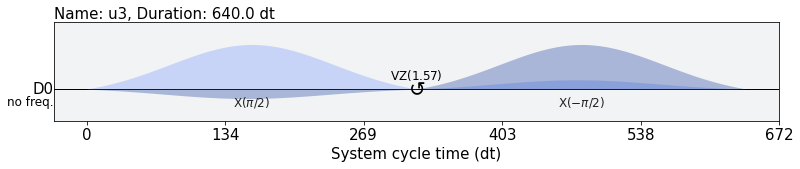

In [8]:
inst_sched_map = calibration.backend.defaults().instruction_schedule_map
inst_sched_map.get('u3', 0, np.pi/2, 0, 0).draw();

Now we compile something analogous using our pulses and a frame change:

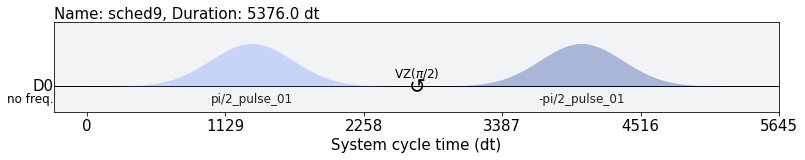

In [9]:
schedule = pulse.Schedule()
schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration

schedule.draw();

## Running random rotations

Let's start doing some experiments that can be used for shadow state tomography.

In the following code, we generate a sequence of schedules that each contain four gates.
These gates will be randomly chosen from our four rotations.

In [10]:
num_sched = 75
basis = ['Rx_01', 'Ry_01', 'Rx_12', 'Ry_12']

if num_sched > 75:
    raise ValueError("You can only run 75 schedules at a time.")

rotations, schedules = [], []
for _ in range(num_sched):
    gates, schedule = [], pulse.Schedule()
    for _ in range(4):
        gate = np.random.choice(basis)
        gates.append(gate)
        if gate == 'Rx_01':
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_01':
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Rx_12':
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_12':
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration
    schedule |= calibration.measure << schedule.duration

    schedules.append(schedule)
    rotations.append(gates)

program = assemble(
    schedules,
    backend=calibration.backend,
    meas_level=1,
    meas_return='single',
    shots=calibration.num_shots,
    schedule_los=[{calibration.drive_chan: cal_qubit_freq}] * num_sched
)

Now let's run the job on the backend and see what we get:

In [11]:
job = calibration.backend.run(program)

print('Job ID: ' + job.job_id())
job_monitor(job)

Job ID: 61011db72cbc4177c0cba999
Job Status: job has successfully run


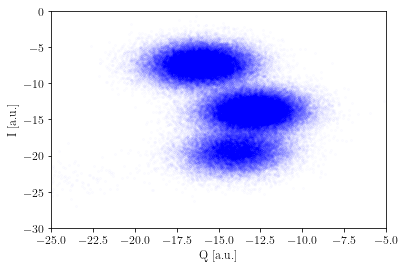

In [12]:
from src.plotting_utils import *

data = get_job_data(job, average=False, qubit_idx=calibration.qubit, scale_factor=calibration.scale_factor)
plt.scatter(np.real(data), np.imag(data), s=5, cmap='viridis', c='blue', alpha=0.01)

x_min = -25
x_max = -5
y_min = -30
y_max = 0

plt.xlim(x_min, x_max)
plt.ylim(y_min,y_max)
plt.ylabel('I [a.u.]')
plt.xlabel('Q [a.u.]');

Now this is hardly the most convincing experiment, but we can see that there are three lobes in the IQ plot corresponding to each of the three levels.

This *roughly* what you'd expect to see if you were running random gates that should span the state space.

## Running random circuits then undoing them

Let's try to get a better indicator of how the calibrated rotations are performing.
We again run sequences of random rotations, but this time we will run the inverted sequence afterwards.
If the rotations are performing well, we should get back the initial state $|0\rangle$:

In [13]:
rotations, schedules = [], []
for _ in range(num_sched):
    gates, schedule = [], pulse.Schedule()

    for _ in range(4):
        gate = np.random.choice(basis)
        gates.append(gate)
        if gate == 'Rx_01':
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_01':
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Rx_12':
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_12':
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration

    for j in range(len(gates)):
        gate = gates[-(j+1)]
        if gate == 'Rx_01':
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_01':
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Rx_12':
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_12':
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
    schedule |= calibration.measure << schedule.duration

    schedules.append(schedule)
    rotations.append(gates)

program = assemble(
    schedules,
    backend=calibration.backend,
    meas_level=1,
    meas_return='single',
    shots=calibration.num_shots,
    schedule_los=[{calibration.drive_chan: cal_qubit_freq}] * num_sched
)

In [14]:
job = calibration.backend.run(program)

print('Job ID: ' + job.job_id())
job_monitor(job)

Job ID: 61011ed9fd11f373c9c68c4e
Job Status: job has successfully run


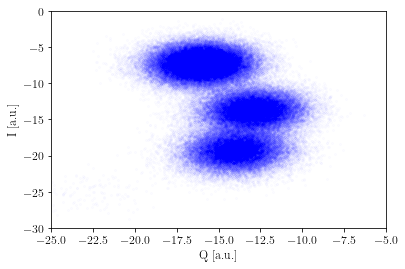

In [15]:
data = get_job_data(job, average=False, qubit_idx=calibration.qubit, scale_factor=calibration.scale_factor)
plt.scatter(np.real(data), np.imag(data), s=5, cmap='viridis', c='blue', alpha=0.01)

x_min = -25
x_max = -5
y_min = -30
y_max = 0

plt.xlim(x_min, x_max)
plt.ylim(y_min,y_max)
plt.ylabel('I [a.u.]')
plt.xlabel('Q [a.u.]');

This is pretty rough.
The final state should always be $|0\rangle$, but this only is true ~51% of the time.

If we repeat this experiment with only the $\{0,1\}$ pulses, the accuracy increases to ~68%.

All-in-all, the gates are quite noisy. Let's see if reducing the circuit depth helps:

In [16]:
rotations, schedules = [], []
for _ in range(num_sched):
    gates, schedule = [], pulse.Schedule()

    for _ in range(2):
        gate = np.random.choice(basis)
        gates.append(gate)
        if gate == 'Rx_01':
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_01':
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Rx_12':
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_12':
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(-np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration

    for j in range(len(gates)):
        gate = gates[-(j+1)]
        if gate == 'Rx_01':
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_01':
            schedule |= pulse.Play(mpi2_pulse_01, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(pi2_pulse_01, calibration.drive_chan) << schedule.duration
        elif gate == 'Rx_12':
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration
        elif gate == 'Ry_12':
            schedule |= pulse.Play(mpi2_pulse_12, calibration.drive_chan) << schedule.duration
            schedule |= pulse.ShiftPhase(np.pi/2, calibration.drive_chan) << schedule.duration
            schedule |= pulse.Play(pi2_pulse_12, calibration.drive_chan) << schedule.duration
    schedule |= calibration.measure << schedule.duration

    schedules.append(schedule)
    rotations.append(gates)

program = assemble(
    schedules,
    backend=calibration.backend,
    meas_level=1,
    meas_return='single',
    shots=calibration.num_shots,
    schedule_los=[{calibration.drive_chan: cal_qubit_freq}] * num_sched
)

In [17]:
job = calibration.backend.run(program)

print('Job ID: ' + job.job_id())
job_monitor(job)

Job ID: 61011feffd11f3e3d8c68c51
Job Status: job has successfully run


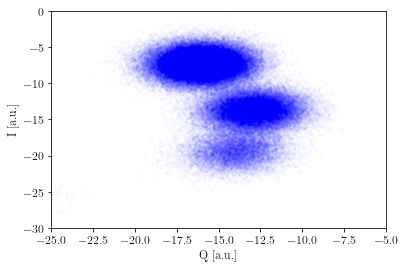

In [18]:
data = get_job_data(job, average=False, qubit_idx=calibration.qubit, scale_factor=calibration.scale_factor)
plt.scatter(np.real(data), np.imag(data), s=5, cmap='viridis', c='blue', alpha=0.01)

x_min = -25
x_max = -5
y_min = -30
y_max = 0

plt.xlim(x_min, x_max)
plt.ylim(y_min,y_max)
plt.ylabel('I [a.u.]')
plt.xlabel('Q [a.u.]');

Better but still bad.